In [1]:
import xlab # for testing your code
xlab.hello_world()

from robustbench.utils import load_model
from robustbench.data import load_cifar10

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import matplotlib.pyplot as plt
from autoattack import AutoAttack
# import torchattacks
import pickle
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

Hello world! You are using version 0.1.7 of the package


In [2]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to('mps')
_ = model.eval()

In [3]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


In [4]:
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


In [35]:
def f_6(logits, target):
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([logits[:target], logits[target+1:]]))
    return F.relu(logits[i_neq_t] - logits[target])
            

def CW_targeted(img, model, c, target):
    
    cw_weights = torch.randn_like(img, requires_grad=True).to('mps')
    optimizer = optim.Adam([cw_weights], lr=1e-1)

    num_iters = 200
    delta = 0.5 * (F.tanh(cw_weights) + 1) - img

    for i in range(num_iters):
        
        logits = model((img + delta).unsqueeze(0))

        if torch.argmax(logits[0]) == target and torch.max(torch.abs(delta)) < 8/255:
            return delta

        success_loss = c * f_6(logits[0], target)
        l2_reg = torch.sum((delta)**2)

        loss = success_loss + l2_reg
        print(loss, success_loss, l2_reg)
        
        loss.backward()

        # print(cw_weights)
        # print(cw_weights.grad)
        optimizer.step()
        optimizer.zero_grad()

        

        delta = 0.5 * (F.tanh(cw_weights) + 1) - img
    print("warning! targeted attack was not successful")
    return delta

In [36]:
x = x_test[0]

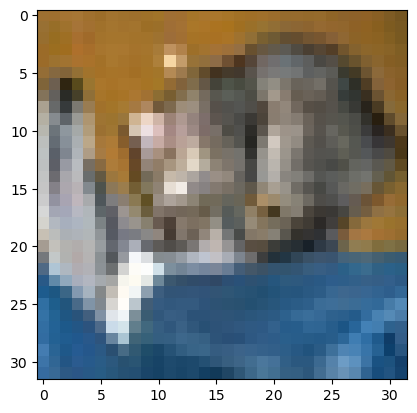

In [37]:
plt.imshow(x.permute(1,2,0).cpu())

In [38]:
out_delta = CW_targeted(x.to('mps'), model, 0.005, 0)

tensor(428.4894, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0559, device='mps:0', grad_fn=<MulBackward0>) tensor(428.4335, device='mps:0', grad_fn=<SumBackward0>)
tensor(383.1781, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0557, device='mps:0', grad_fn=<MulBackward0>) tensor(383.1224, device='mps:0', grad_fn=<SumBackward0>)
tensor(340.6284, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0558, device='mps:0', grad_fn=<MulBackward0>) tensor(340.5726, device='mps:0', grad_fn=<SumBackward0>)
tensor(301.1933, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0563, device='mps:0', grad_fn=<MulBackward0>) tensor(301.1370, device='mps:0', grad_fn=<SumBackward0>)
tensor(264.8531, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0566, device='mps:0', grad_fn=<MulBackward0>) tensor(264.7965, device='mps:0', grad_fn=<SumBackward0>)
tensor(231.5567, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0560, device='mps:0', grad_fn=<MulBackward0>) tensor(231.5008, device='mps:0', grad_fn=<S

In [39]:
out_delta.shape

torch.Size([3, 32, 32])

In [40]:
8/255

0.03137254901960784

In [41]:
out_delta.min()

tensor(-0.0305, device='mps:0', grad_fn=<MinBackward1>)

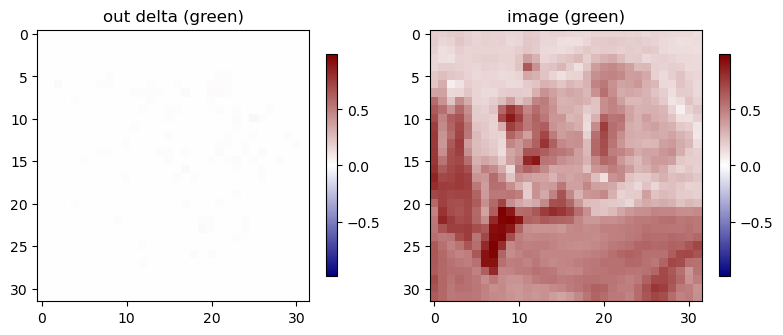

In [42]:
_ = xlab.utils.plot_tensors(
    [out_delta[2].detach().cpu(), x.cpu()[2]], # plot only red channel, ignore green & blue
    log_scale=False, 
    ncols=2,
    titles = ["out delta (green)", "image (green)"]
)

In [43]:
x_adv = out_delta + x

In [44]:
model(x_adv.unsqueeze(0))

tensor([[13.4251, -0.7176, -1.3678,  3.0889, -5.2713, -1.6484, -1.6464, -2.5078,
         -1.8055, -1.4932]], device='mps:0', grad_fn=<LinearBackward0>)

In [45]:
x_adv.shape

torch.Size([3, 32, 32])

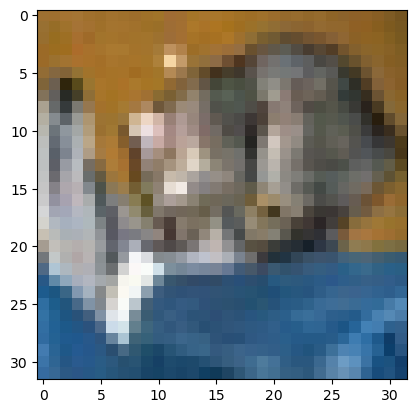

In [46]:
plt.imshow(x_adv.detach().permute(1,2,0).cpu())